In [2]:
#from __future__ import division, print_function
import matplotlib.pyplot as plt
import bilby
import numpy as np

import time

from bilby.core.prior import Uniform
#from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

import hphc10
import hphc9

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
np.random.seed(1234)

In [3]:
outdir = 'outdir_new_model'
label = 'create_your_own_source_model'
sampling_frequency = 1024
duration = 4

In [35]:
def eccentric_waveform(frequency_array_, mass_1, mass_2, eccentricity, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec):
    frequency_array = np.array(frequency_array_)
    minimum_f = 20.0
    maximum_f = (C**3)/( G*(mass_1+mass_2)*Mo*np.pi*6**(3/2) )
    
    N = len(frequency_array)
    h_plus = np.zeros(N)*1j
    h_cross = np.zeros(N)*1j
    
    k = 0
    for f in frequency_array:
        if f>=minimum_f and f<=maximum_f:
            arg_plus = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'et0_':eccentricity, 'phic_':phase, 'tc_':geocent_time}

            fplus = hphc9.Fn(**arg_plus)

            h_plus[k] = fplus.htilde()[0]
            h_cross[k] = fplus.htilde()[1]

        k=k+1
    #return {'plus': h_plus, 'cross': h_cross}
    return {'plus': h_plus, 'cross': h_cross}

In [13]:
def eccentric_waveform(frequency_array_, mass_1, mass_2, eccentricity, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec):
    
    minimum_f = 20.0
    maximum_f = (C**3)/( G*(mass_1+mass_2)*Mo*np.pi*6**(3/2) )
    
    frequency_array = frequency_array_[(frequency_array_>=minimum_f) & (frequency_array_<=maximum_f)]
    before = frequency_array_[(frequency_array_<minimum_f)]*0.0
    after = frequency_array_[(frequency_array_>maximum_f)]*0.0
    
    N = len(frequency_array)
    h_plus = np.zeros(N)*1j
    h_cross = np.zeros(N)*1j
    
    k = 0
    for f in frequency_array:

        arg_plus = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'et0_':eccentricity, 'phic_':phase, 'tc_':geocent_time}

        fplus = hphc9.Fn(**arg_plus)

        h_plus[k] = fplus.htilde()[0]
        h_cross[k] = fplus.htilde()[1]

        k=k+1
    #return {'plus': h_plus, 'cross': h_cross}
    return {'plus': np.concatenate((before,h_plus,after)), 'cross': np.concatenate((before,h_cross,after))}

In [5]:
#eccentric_waveform(np.arange(0,100,1),35.0,30.0,0.1,440.0,0.4,0.1,1.2,1180002601.0,45,5.73)

In [37]:
import time 

fff = np.arange(0,512,0.25)
t0 = time.time()
zz = eccentric_waveform(fff,35.0,30.0,0.1,440.0,0.4,0.1,1.2,1180002601.0,45,5.73)

t1 = time.time()
print('Execution took {:.4f}'.format(t1 - t0))

Execution took 18.9247


In [7]:
'''
import pandas as pd 

yy = {'frequency': H1.strain_data.frequency_array[:]} 
yy.update(zz)
df = pd.DataFrame(yy, columns = ['frequency', 'plus', 'cross'])
df.to_csv('raw_data.csv', index=False)
'''

"\nimport pandas as pd \n\nyy = {'frequency': H1.strain_data.frequency_array[:]} \nyy.update(zz)\ndf = pd.DataFrame(yy, columns = ['frequency', 'plus', 'cross'])\ndf.to_csv('raw_data.csv', index=False)\n"

In [23]:
injection_parameters = dict(mass_1=36.0, mass_2=29.0, eccentricity=0.1, luminosity_distance=4000.0, theta_jn=0.4, psi=2.659, phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

In [24]:
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=eccentric_waveform)


13:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.eccentric_waveform
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [25]:
# Set up interferometers.
minimum_frequency = 20.0+5.0
MM1 = 35.0
MM2 = 30.0
maximum_frequency = (C**3)/( G*(MM1+MM2)*Mo*np.pi*6**(3/2) )-5.0

ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
for ifo in ifos:
    ifo.minimum_frequency = minimum_frequency
    ifo.maximum_frequency = maximum_frequency
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
13:52 bilby INFO    : Injected signal in H1:
13:52 bilby INFO    :   optimal SNR = 3.78
13:52 bilby INFO    :   matched filter SNR = 5.30-0.05j
13:52 bilby INFO    :   mass_1 = 36.0
13:52 bilby INFO    :   mass_2 = 29.0
13:52 bilby INFO    :   eccentricity = 0.1
13:52 bilby INFO    :   luminosity_distance = 4000.0
13:52 bilby INFO    :   theta_jn = 0.4
13:52 bilby INFO    :   psi = 2.659
13:52 bilby INFO    :   phase = 1.3
13:52 bilby INFO    :   geocent_time = 1126259642.413
13:52 bilby INFO    :   ra = 1.375
13:52 bilby INFO    :   dec = -1.2108
13:52 bilby INFO    : Injected signal in L1:
13:52 bilby INFO    :   optimal SNR = 3.07
13:52 bilby INFO    :   matched filter SNR = 3.20+0.06j
13:52 bilby INFO    :   mass_1 =

In [11]:
#aa = np.array(H1_injection["cross"])
#print(aa[0:200])
#aa = H1_injection["plus"][idxs]
#print(aa)

In [33]:
np.arange(0,10,0.25)

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ,
       2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25,
       4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  , 6.25, 6.5 ,
       6.75, 7.  , 7.25, 7.5 , 7.75, 8.  , 8.25, 8.5 , 8.75,
       9.  , 9.25, 9.5 , 9.75])

In [30]:
H1.frequency_array[:]

array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 5.1150e+02,
       5.1175e+02, 5.1200e+02])

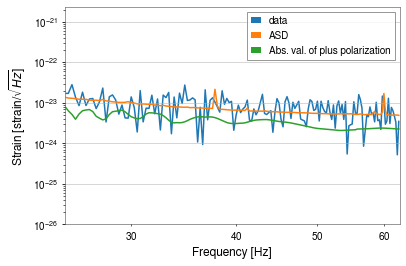

In [26]:
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["cross"][idxs]),
          label="Abs. val. of plus polarization")

ax.set_xlim(minimum_frequency,maximum_frequency)
ax.set_ylim(1e-26,2.327737159425905e-21)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [18]:
#injection_parameters = dict(mass_1=35.0, mass_2=30.0, eccentricity=0.1, luminosity_distance=440.0, 
#theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=1.375, dec=-1.2108)
prior = injection_parameters.copy()
prior['eccentricity'] = bilby.core.prior.LogUniform(
    name='eccentricity', latex_label='$e$', minimum=1e-4, maximum=0.4)


'''
priors = bilby.core.prior.PriorDict()
priors["mass_1"] = 10.0
priors["mass_2"] = 10.0
priors["eccentricity"] = Uniform(name='eccentricity', minimum=0.01,maximum=0.4)
priors["luminosity_distance"] = 100.
priors["theta_jn"] = 1.0471975511965976
priors["psi"] = 1.0471975511965976
priors["phase"] = 0.0
priors["geocent_time"] = 1180002601.0
priors["ra"] = 1.375
priors["dec"] = -1.2108
'''

'\npriors = bilby.core.prior.PriorDict()\npriors["mass_1"] = 10.0\npriors["mass_2"] = 10.0\npriors["eccentricity"] = Uniform(name=\'eccentricity\', minimum=0.01,maximum=0.4)\npriors["luminosity_distance"] = 100.\npriors["theta_jn"] = 1.0471975511965976\npriors["psi"] = 1.0471975511965976\npriors["phase"] = 0.0\npriors["geocent_time"] = 1180002601.0\npriors["ra"] = 1.375\npriors["dec"] = -1.2108\n'

In [19]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator)

03:52 bilby INFO    : Running for label 'create_your_own_source_model', output will be saved to 'outdir_new_model'
03:52 bilby INFO    : Using lal version 6.21.0
03:52 bilby INFO    : Using lal git version Branch: None;Tag: lal-v6.21.0;Id: 37caf89936b637993c30b3076fe4b853311873ee;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
03:52 bilby INFO    : Using lalsimulation version 1.10.0
03:52 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v1.10.0;Id: 5bfe091197594d55cf634f8a1c004eb9dc9b6459;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
03:52 bilby INFO    : Search parameters:
03:52 bilby INFO    :   eccentricity = LogUniform(minimum=0.0001, maximum=0.4, name='eccentricity', latex_label='$e$', unit=None, boundary=None)
03:52 bilby INFO    :   mass_1 = 36.0
03:52 bilby INFO    :   mass_2 = 29.0
03:52 bilby INFO    :   luminosity_distance = 4000.0
03:52 bilb

0it [00:00, ?it/s]

03:58 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 16, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f2a98461310>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
03:58 bilby INFO    : Checkpoint every check_point_delta_t = 600s
03:58 bilby INFO    : Using dynesty version 1.0.1
03:58 bilby INFO    : Generating initial points from the pr

688it [1:05:59,  1.14s/it, bound:0 nc:  3 ncall:2.0e+03 eff:34.5% logz-ratio=14.64+/-0.04 dlogz:0.891>0.1]

05:04 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
05:04 bilby INFO    : Writing 1094 current samples to outdir_new_model/create_your_own_source_model_samples.dat


1410it [1:23:23,  1.81s/it, bound:0 nc:  6 ncall:4.0e+03 eff:35.3% logz-ratio=15.19+/-0.03 dlogz:0.339>0.1]

05:22 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
05:22 bilby INFO    : Writing 1082 current samples to outdir_new_model/create_your_own_source_model_samples.dat


1816it [1:40:44,  4.03s/it, bound:0 nc:  6 ncall:6.0e+03 eff:30.2% logz-ratio=15.31+/-0.03 dlogz:0.213>0.1]

05:39 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
05:39 bilby INFO    : Writing 1103 current samples to outdir_new_model/create_your_own_source_model_samples.dat


2101it [1:58:03,  5.61s/it, bound:0 nc: 12 ncall:8.0e+03 eff:26.2% logz-ratio=15.37+/-0.02 dlogz:0.156>0.1]

05:56 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
05:56 bilby INFO    : Writing 1098 current samples to outdir_new_model/create_your_own_source_model_samples.dat


2307it [2:16:11,  7.55s/it, bound:0 nc: 16 ncall:1.0e+04 eff:22.8% logz-ratio=15.40+/-0.02 dlogz:0.125>0.1]

06:14 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
06:14 bilby INFO    : Writing 1121 current samples to outdir_new_model/create_your_own_source_model_samples.dat


2492it [2:33:57,  7.88s/it, bound:0 nc: 16 ncall:1.2e+04 eff:20.6% logz-ratio=15.42+/-0.02 dlogz:0.103>0.1]

06:32 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
06:32 bilby INFO    : Writing 1054 current samples to outdir_new_model/create_your_own_source_model_samples.dat


2516it [2:36:13,  3.72s/it, bound:0 nc:  1 ncall:1.2e+04 eff:22.0% logz-ratio=15.45+/-0.02 dlogz:0.079>0.1]

06:34 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
06:34 bilby INFO    : Writing 1109 current samples to outdir_new_model/create_your_own_source_model_samples.dat
06:34 bilby INFO    : Starting to close worker pool.
06:34 bilby INFO    : Finished closing worker pool.


2516it [2:36:17,  3.73s/it, bound:0 nc:  1 ncall:1.2e+04 eff:28.5% logz-ratio=15.53+/-nan dlogz:0.000>0.1] 

06:34 bilby INFO    : Sampling time: 1:39:21.751654


06:34 bilby INFO    : Summary of results:
nsamples: 3516
ln_noise_evidence: -166.744
ln_evidence: -151.217 +/-    nan
ln_bayes_factor: 15.527 +/-    nan



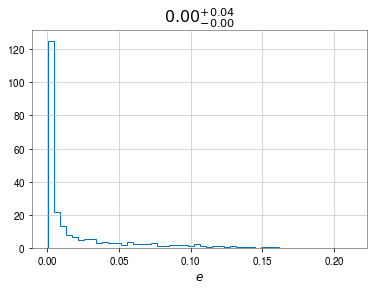

In [20]:
'''
result = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', outdir=outdir, label=label,
    resume=False, sample='unif', injection_parameters=injection_parameters, 
    nlive=500, clean=True, npool=16)
'''
result = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', outdir=outdir, label=label,
    resume=False, sample='unif', injection_parameters=injection_parameters, npool=16)
result.plot_corner()


In [16]:
len(result.samples)

637